# PUI2016 Final Exam

## Motivation:

One of the things that make NYC so interesting to study is its diversity on many axes: ethnic, economic, cultural. Neighborhoods tend to be segregated and clustered on most socioeconomic characteristics, however these characteristics evolve over time. The goal is to identify NYC neighborhoods that are homogeneous by clustering their socioeconomic characteristics in 2000, and in 2010, and find the neighborhoods that change cluster, indicating that they evolve differently with respect to their cluster peers (e.g. gentrification).

In [1]:
import pandas as pd 
import pylab as pl
import numpy as np
import zipfile
from geopandas import GeoDataFrame
import geopandas as gp
from fiona.crs import from_epsg
import os
import ast
import json
import urllib
import io
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### 1) Find the number of businesses in 2000 and 2010

#### Read in business data 

In [2]:
#!for ((y=0; y<=1; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp0$y\totals.zip; done

#!for ((y=10; y<=11; y+=1)); do wget ftp://ftp.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done

In [3]:
# Saving data from 2000 and 2010 in one dataframe 
biz = pd.DataFrame()

for i in range(0,1):
    fname = 'zbp0' + str(i) + 'totals.zip'
    zf = zipfile.ZipFile(fname)
    temp_df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
    temp_df['year'] = i + 2000
    temp_df.columns = [x.lower() for x in temp_df.columns] #Make all columns lowercase to merge across dfs.
    biz = biz.append(temp_df) 
    
for i in range(10,11):
    fname = 'zbp' + str(i) + 'totals.zip'
    zf = zipfile.ZipFile(fname)
    temp_df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
    temp_df['year'] = i + 2000
    temp_df.columns = [x.lower() for x in temp_df.columns]
    biz = biz.append(temp_df) 

In [4]:
biz = biz[['zip','est','year']]
biz['zip'] = biz['zip'].fillna(0.0).astype(int)
biz.index = biz.zip

### 2) Gather a zipcode shapefile and merge the number of businesses with the zipcode shapefile

#### Read in zipcode data 

In [5]:
# Data file sourced from HW11
zip_codes = GeoDataFrame.from_file(os.getenv('PUIDATA') + '/nyc-zip-code-tabulation-areas-polygons.geojson')

In [6]:
zip_codes.rename(columns={'postalCode': 'zip'}, inplace = True)
zip_codes = zip_codes[['PO_NAME','borough','geometry','zip']]
zip_codes['zip'] = zip_codes['zip'].astype(int)
zip_codes.head(3)

,PO_NAME,borough,geometry,zip
0,Jackson Heights,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,Glen Oaks,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,New Hyde Park,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040


In [7]:
# Creating list of NYC zipcodes from shapefile
zipsNYC = zip_codes.zip.values

In [8]:
# Reformat zipcodes in biz (buildings) file
biz = biz.ix[zipsNYC].dropna(how='any')
biz.reset_index(drop=True, inplace=True)
biz['zip'] = biz['zip'].astype(int)
biz['year'] = biz['year'].astype(int)

In [9]:
biz.head(3)

,zip,est,year
0,11372,1409.0,2000
1,11372,1629.0,2010
2,11004,189.0,2000


#### Merged business census data & shapefile 

In [10]:
data = pd.merge(zip_codes, biz, how = 'left', on = 'zip')
data = data.dropna(how = 'any')
data['zip'] = data['zip'].astype(int)
data['year'] = data['year'].astype(int)
data.head(3)

,PO_NAME,borough,geometry,zip,est,year
0,Jackson Heights,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372,1409.0,2000
1,Jackson Heights,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372,1629.0,2010
2,Glen Oaks,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004,189.0,2000


### 3) Find the density of the businesses and show them in a chloropleth map

In [11]:
# Calculate area of each shape & business density
data['area'] = zip_codes.to_crs(epsg=2263).geometry.area /(2.788*10**7)  # from ft2 to mi2 
data['density'] = data['est'] / data['area']
data.head()

,PO_NAME,borough,geometry,zip,est,year,area,density
0,Jackson Heights,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372,1409.0,2000,0.724037,1946.032637
1,Jackson Heights,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372,1629.0,2010,0.811527,2007.325937
2,Glen Oaks,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004,189.0,2000,0.224615,841.441570
3,Glen Oaks,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004,229.0,2010,1.771526,129.267068
4,New Hyde Park,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040,1350.0,2000,2.490261,542.111920


In [12]:
# Segment data by year 2000 and 2010
biz2000 = data[data['year'] == 2000]
biz2010 = data[data['year'] == 2010]

#### Plotting the data

(-74.299999999999997,
 -73.599999999999994,
 40.400000000000006,
 41.000000000000007)

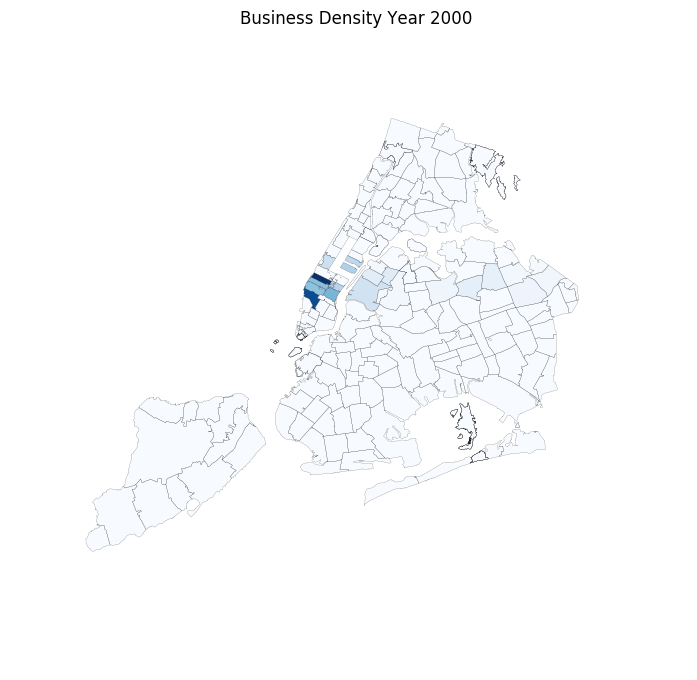

In [13]:
fig, ax = pl.subplots(figsize = (8,8))
biz2000.plot(column='density',cmap = 'Blues',alpha=1,linewidth=0.1,ax=ax)
ax.set_title('Business Density Year 2000')
ax.axis('off')

Figure 1: a) This figure shows the density of businesses across New York City at the zip code level for the year 2000. The darker color represents a higher density and is largely concentrated in midtown Manhattan. Astoria and Long Island City, Queens have noticeable densities also. 

(-74.299999999999997,
 -73.599999999999994,
 40.400000000000006,
 41.000000000000007)

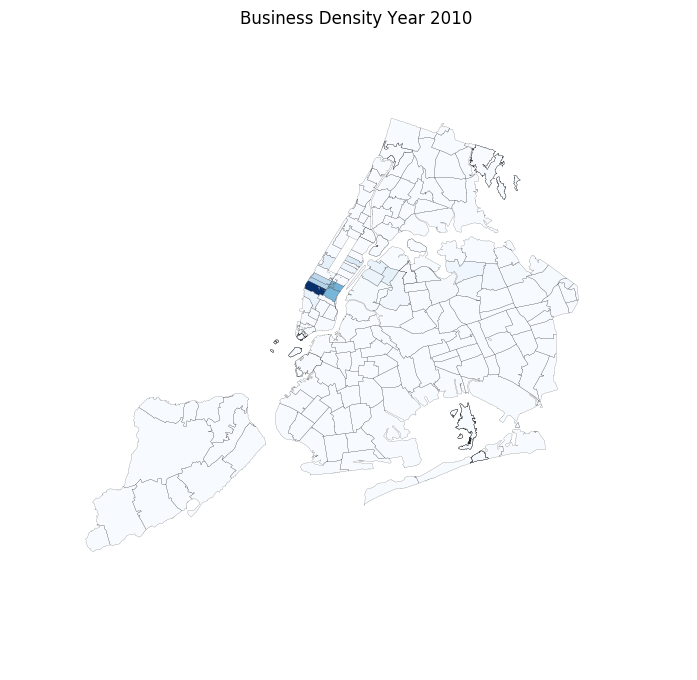

In [14]:
fig, ax = pl.subplots(figsize = (8,8))
biz2010.plot(column='density',cmap ='Blues',alpha=1,linewidth=0.1,ax=ax)
ax.set_title('Business Density Year 2010')
ax.axis('off')

Figure 1: b) This figure shows the density of businesses across New York City at the zip code level for the year 2010. The higher densities are still largely concentrated in midtown Manhattan though the placement has shifted slightly. Queens densities are beginning to fade. 

### 4) Collect census data for 2000 and 2010 and extract the estimate age, total population, and diversity of each tract for all 5 NYC boroughs

Query to access Census 2000 and 2010 data from fb55's CartoDB acct.

In [15]:
source = 'https://fb55.cartodb.com/api/v2/sql'

def queryCartoDB_py3(source, query, format='CSV'):
    """queries data from CartoDB SQL database
    Arguments:
    query: a string like 
            SELECT colum_name_1, column_name_2 FROM database_name
    format: the file format (e.g. CSV, GeoJson)
    source: the sql database url link
    Return:
        database as a string to be read in with the appropriate function
    """
    p = urllib.parse.urlencode({'q':query,
                                'format':format
                                })
    with urllib.request.urlopen(source + '?' + p) as response:
        the_page = response.read().decode('utf8')
    return the_page
    #except:
    #    print('Error occurred')

#### Census 2000 data 

In [16]:
query = ''' SELECT * FROM DEC_00_SF1_DP1'''

url = source +\
      "?q= "+ query
    
print (url)

result = queryCartoDB_py3(source, query, 'CSV')
census2000 = pd.read_csv(io.StringIO(result))

https://fb55.cartodb.com/api/v2/sql?q=  SELECT * FROM DEC_00_SF1_DP1


In [17]:
census2000 = census2000[['geo_id2','geo_display_label','hc01_vc01','hc02_vc29','hc01_vc18']]
census2000.rename(columns={'hc01_vc01': 'total_population', 'hc02_vc29': 'percent_white', 'hc01_vc18':'median_age'}, 
                  inplace=True)
census2000.tail(3)

,geo_id2,geo_display_label,total_population,percent_white,median_age
4904,36123990300,"Census Tract 9903, Yates County, New York",5225,98.2,38.1
4905,36123990400,"Census Tract 9904, Yates County, New York",3975,98.2,38.0
4906,36123990500,"Census Tract 9905, Yates County, New York",4145,98.6,37.3


#### Census 2010 data 

In [18]:
query = ''' SELECT * FROM DEC_10_SF1_SF1DP1'''

url = source +\
      "?q= "+ query
    
print (url)

result = queryCartoDB_py3(source, query, 'CSV')
census2010 = pd.read_csv(io.StringIO(result))

https://fb55.cartodb.com/api/v2/sql?q=  SELECT * FROM DEC_10_SF1_SF1DP1


In [19]:
census2010 = census2010[['geo_id2','geo_display_label','hd01_s001','hd02_s078','hd01_s020']]
census2010.rename(columns={'hd01_s001': 'total_population', 'hd02_s078': 'percent_white', 'hd01_s020':'median_age'}, 
                  inplace=True)
census2010.tail(3)

,geo_id2,geo_display_label,total_population,percent_white,median_age
4916,36123150300,"Census Tract 1503, Yates County, New York",5348,98.1,43.4
4917,36123150400,"Census Tract 1504, Yates County, New York",3973,96.2,38.7
4918,36123150500,"Census Tract 1505, Yates County, New York",4524,97.8,40.6


### 5) Collect the income data for 2000 and 2010 by census tract from American Fact Finder

#### Income 2000 data 

In [20]:
query = ''' SELECT * FROM DEC_00_SF3_DP3_with_ann'''

url = source +\
      "?q= "+ query
    
print (url)

result = queryCartoDB_py3(source, query, 'CSV')
income2000 = pd.read_csv(io.StringIO(result))

https://fb55.cartodb.com/api/v2/sql?q=  SELECT * FROM DEC_00_SF3_DP3_with_ann


In [21]:
income2000 = income2000[['geo_id2','hc01_vc64']]
income2000.rename(columns={'hc01_vc64': 'med_household_inc'}, inplace=True)
income2000.head(3)

,geo_id2,med_household_inc
0,36089991900,0
1,36001013703,68929
2,36005000200,42539


#### Income 2010 data 

In [22]:
query = ''' SELECT * FROM ACS_10_5YR_S1901_with_ann'''

url = source +\
      "?q= "+ query
    
print (url)

result = queryCartoDB_py3(source, query, 'CSV')
income2010 = pd.read_csv(io.StringIO(result))

https://fb55.cartodb.com/api/v2/sql?q=  SELECT * FROM ACS_10_5YR_S1901_with_ann


In [23]:
income2010 = income2010[['geo_id2','hc01_est_vc13']]
income2010.rename(columns={'hc01_est_vc13': 'med_household_inc'}, inplace=True)
income2010.head(3)

,geo_id2,med_household_inc
0,36001000100,32333
1,36001000200,25354
2,36001000300,30932


### 6) Merge the datasets for each year

#### Merging the datasets

In [24]:
data2000 = pd.merge(census2000, income2000, how = 'left', on = 'geo_id2')
data2010 = pd.merge(census2010, income2010, how = 'left', on = 'geo_id2')
data2010.replace(to_replace = '-', value = 0, inplace=True)
data2010['med_household_inc'] = pd.to_numeric(data2010['med_household_inc'],errors = 'coerce')
data2010['med_household_inc'] = data2010['med_household_inc'].fillna(0.0)

In [25]:
data2000.head(3)

,geo_id2,geo_display_label,total_population,percent_white,median_age,med_household_inc
0,36047054300,"Census Tract 543, Kings County, New York",0,NaN,0.0,0
1,36081121100,"Census Tract 1211, Queens County, New York",0,NaN,0.0,0
2,36005003700,"Census Tract 37, Bronx County, New York",478,18.4,22.0,23750


In [26]:
data2010.head(3)

,geo_id2,geo_display_label,total_population,percent_white,median_age,med_household_inc
0,36081038301,"Census Tract 383.01, Queens County, New York",0,NaN,0.0,0.0
1,36005002400,"Census Tract 24, Bronx County, New York",4,50.0,38.0,0.0
2,36059990200,"Census Tract 9902, Nassau County, New York",0,NaN,0.0,0.0


### 7) Merge the dataframe with the census tract shapefile and display each of the features in a chloropleth map for 2000 and 2010

In [27]:
# Census tract data file sourced from http://www1.nyc.gov/site/planning/data-maps/open-data/districts-download-metadata.page
ct = gp.read_file(os.getenv('PUIDATA') +'/' +'nyct2010_16d'+'/nyct2010.shp')

In [28]:
ct.head(3)

,BoroCT2010,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry
0,5000900,5,Staten Island,I,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016794,"POLYGON ((962269.1260375977 173705.5001831055,..."
1,5007400,5,Staten Island,I,007400,74,SI14,Grasmere-Arrochar-Ft. Wadsworth,3902,5.788238e+06,9902.948473,"POLYGON ((967656.8290405273 155637.1314086914,..."
2,1009800,1,Manhattan,I,009800,98,MN19,Turtle Bay-East Midtown,3808,1.906016e+06,5534.199811,"POLYGON ((994133.507019043 214848.8975830078, ..."


In [29]:
# Creating unique ID to merge data frames
countyID = {'Bronx':'005','Manhattan':'061','Staten Island':'085','Brooklyn':'047','Queens':'081'}
ct['allcodes'] = list(zip(ct.BoroName, ct.CT2010))
ct['geo_id2']  = ct[['allcodes']].applymap(lambda x: 
                            ('36%03d%06d'%(int(countyID[x[0]]),int(x[1]))))
ct['geo_id2'] = ct['geo_id2'].astype(int)
ct = ct[['geometry','geo_id2', 'BoroName']]
ct.head(3)

,geometry,geo_id2,BoroName
0,"POLYGON ((962269.1260375977 173705.5001831055,...",36085000900,Staten Island
1,"POLYGON ((967656.8290405273 155637.1314086914,...",36085007400,Staten Island
2,"POLYGON ((994133.507019043 214848.8975830078, ...",36061009800,Manhattan


#### Merging the datasets

In [30]:
data2000 = pd.merge(ct,data2000, how = 'left', on = 'geo_id2')
data2010 = pd.merge(ct,data2010, how = 'left', on = 'geo_id2')
data2000 = data2000.fillna(0.0)
data2010 = data2010.fillna(0.0)

In [31]:
data2010.tail(3)

,geometry,geo_id2,BoroName,geo_display_label,total_population,percent_white,median_age,med_household_inc
2163,"POLYGON ((997756.6624145508 194645.1395874023,...",36047053100,Brooklyn,"Census Tract 531, Kings County, New York",7027,98.1,13.4,24018.0
2164,"POLYGON ((989311.0202026367 186769.067199707, ...",36047011900,Brooklyn,"Census Tract 119, Kings County, New York",1530,70.7,33.2,55156.0
2165,"POLYGON ((987657.6373901367 183942.375793457, ...",36047012100,Brooklyn,"Census Tract 121, Kings County, New York",1619,64.4,31.7,54336.0


#### Plotting the data

In [32]:
# Resetting projection
data2000 = data2000.to_crs({'init': 'epsg:4326'}) 
data2010 = data2010.to_crs({'init': 'epsg:4326'}) 

(-74.299999999999997,
 -73.699999999999989,
 40.400000000000006,
 41.000000000000007)

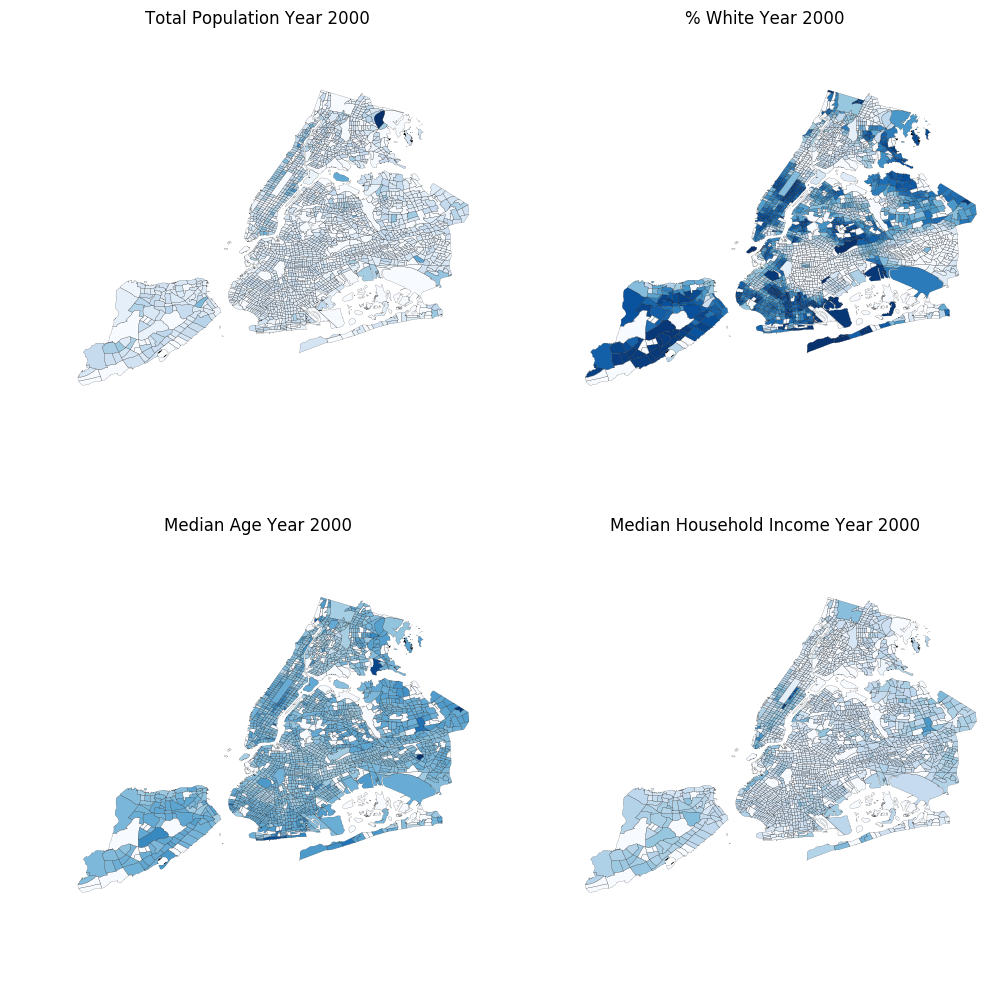

In [33]:
f, ((ax1, ax2), (ax3, ax4)) = pl.subplots(2, 2, figsize=(12,12))
pl.title('Year 2000 Demographic Data')

data2000.plot(column='total_population',cmap = 'Blues',alpha=1,linewidth=0.1,ax=ax1)
ax1.set_title('Total Population Year 2000')
ax1.axis('off')

data2000.plot(column='percent_white',cmap = 'Blues',alpha=1,linewidth=0.1,ax=ax2)
ax2.set_title('% White Year 2000')
ax2.axis('off')

data2000.plot(column='median_age',cmap = 'Blues',alpha=1,linewidth=0.1,ax=ax3)
ax3.set_title('Median Age Year 2000')
ax3.axis('off')

data2000.plot(column='med_household_inc',cmap = 'Blues',alpha=1,linewidth=0.1,ax=ax4)
ax4.set_title('Median Household Income Year 2000')
ax4.axis('off')

Figure 2: The figures above represent demographic data for the year 2000 in New York City at the census tract level. a) This figure shows the population of each census tract for NYC. The higher populations appear in upper Manhattan toward Harlemn and the Bronx, parts of Queens and Staten Island. b) This figure shows the percentage of the white population for each census tract. There are higher white populations in midtown Manhattan and Staten Island. c) This figure shows the median age for each census tract. d) This figure shows the median household income for each census tract. The highest median household income appears on the upper east side of Manhattan. 

(-74.299999999999997,
 -73.699999999999989,
 40.400000000000006,
 41.000000000000007)

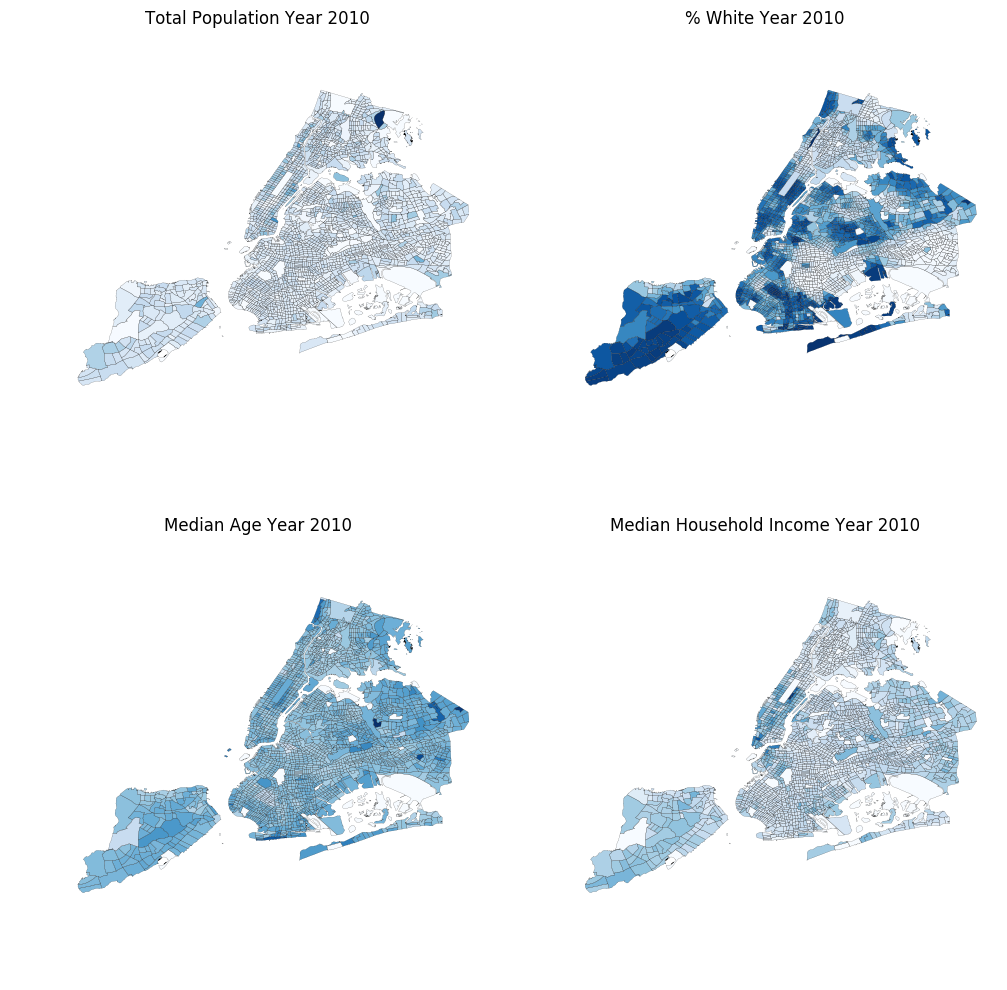

In [34]:
f, ((ax1, ax2), (ax3, ax4)) = pl.subplots(2, 2, figsize=(12,12))
pl.title('Year 2010 Demographic Data')

data2010.plot(column='total_population',cmap = 'Blues',alpha=1,linewidth=0.1,ax=ax1)
ax1.set_title('Total Population Year 2010')
ax1.axis('off')

data2010.plot(column='percent_white',cmap = 'Blues',alpha=1,linewidth=0.1,ax=ax2)
ax2.set_title('% White Year 2010')
ax2.axis('off')

data2010.plot(column='median_age',cmap = 'Blues',alpha=1,linewidth=0.1,ax=ax3)
ax3.set_title('Median Age Year 2010')
ax3.axis('off')

data2010.plot(column='med_household_inc',cmap = 'Blues',alpha=1,linewidth=0.1,ax=ax4)
ax4.set_title('Median Household Income Year 2010')
ax4.axis('off')

Figure 3: The figures above represent demographic data for the year 2010 in New York City at the census tract level. a) This figure shows the population of each census tract for NYC. The higher populations are not as clear for the year 2010. b) This figure shows the percentage of the white population for each census tract. There is a noticeable increase in the white population of Staten Island. c) This figure shows the median age for each census tract. d) This figure shows the median household income for each census tract. The highest median household income appears on the upper east side of Manhattan and the financial district.

In [35]:
# Need to plot the differences in a 3rd chloropleth map
data2010copy = data2010.rename(columns={'total_population': 'total_population2010',
                                        'percent_white': 'percent_white2010','median_age':'median_age2010',
                                        'med_household_inc':'med_household_inc2010'})

demographics = gp.GeoDataFrame(pd.concat([data2000, data2010copy], axis = 1))
demographics['pop_diff'] =  demographics['total_population2010'] / demographics['total_population'] 
demographics['white_diff'] = demographics['percent_white2010'] / demographics['percent_white']
demographics['age_diff'] = demographics['median_age2010'] / demographics['median_age']
demographics['income_diff'] = demographics['med_household_inc2010'] / demographics['med_household_inc']
demographics = demographics[['geo_id2','pop_diff','white_diff','age_diff','income_diff']]
demographics = demographics.loc[:,~demographics.columns.duplicated()]
demographics['geometry'] = data2010['geometry']
demographics = demographics.replace([np.inf, -np.inf], np.nan)
demographics = demographics.dropna()

demographics.tail()

,geo_id2,pop_diff,white_diff,age_diff,income_diff,geometry
2159,36047029600,1.037994,0.855670,1.000000,1.075523,POLYGON ((-73.98869008772979 40.60342530665356...
2160,36005002000,0.962836,1.220430,1.080139,1.697570,POLYGON ((-73.86246402703924 40.81924715411636...
2162,36047025500,1.004924,1.570175,1.137255,1.410083,POLYGON ((-73.94920679216077 40.69537763229062...
2163,36047053100,2.721534,1.264175,0.757062,1.053606,POLYGON ((-73.95128819368698 40.70092236548562...
2165,36047012100,0.901448,1.457014,1.003165,1.495088,POLYGON ((-73.98771576044813 40.67155538114873...


In [36]:
# f, ((ax1, ax2), (ax3, ax4)) = pl.subplots(2, 2, figsize=(12,12))

# demographics.plot(column='pop_diff',cmap = 'Blues',alpha=1,linewidth=0.1,ax=ax1)
# ax1.set_title('Change in Population')
# ax1.axis('off')

# demographics.plot(column='white_diff',cmap = 'Blues',alpha=1,linewidth=0.1,ax=ax2)
# ax2.set_title('Change in % White ')
# ax2.axis('off')

# demographics.plot(column='age_diff',cmap = 'Blues',alpha=1,linewidth=0.1,ax=ax3)
# ax3.set_title('Change in Median Age')
# ax3.axis('off')

# demographics.plot(column='income_diff',cmap = 'Blues',alpha=1,linewidth=0.1,ax=ax4)
# ax4.set_title('Change in Median Household')
# ax4.axis('off')

### 8) Cluster the census tracts on demographic features

#### Calculating the # of Clusters for K-Means

In [37]:
def elbow(data, K):
#data is your input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    '''
    Function that calculates and plots the 'elbow' for kmeans clustering. 
    Developed in NYU CUSP's Applied Data Science Class.
    Inputs: data, number of clusters K
    Outputs: Elbow plot
    '''
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid since we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    
    # elbow curve
    fig = pl.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    pl.grid(True)
    pl.xlabel('Number of clusters')
    pl.ylabel('Average within-cluster sum of squares')
    pl.title('Elbow for KMeans clustering')
    pl.show()
    
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    
    fig = pl.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    pl.grid(True)
    pl.xlabel('Number of clusters')
    pl.ylabel('Percentage of variance explained')
    pl.title('Elbow for KMeans clustering')
    pl.show()

In [38]:
# Segmenting data for clustering
temp_data2000 = data2000[['total_population','percent_white','median_age','med_household_inc']]
temp_data2010 = data2010[['total_population','percent_white','median_age','med_household_inc']]

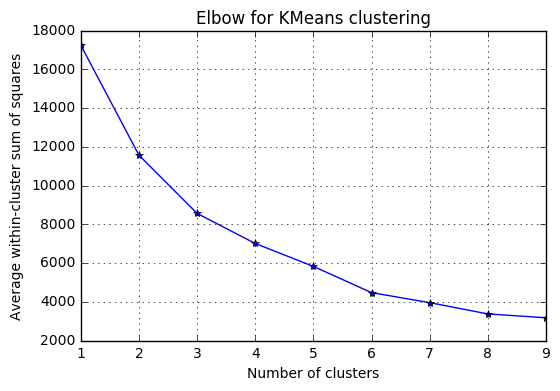

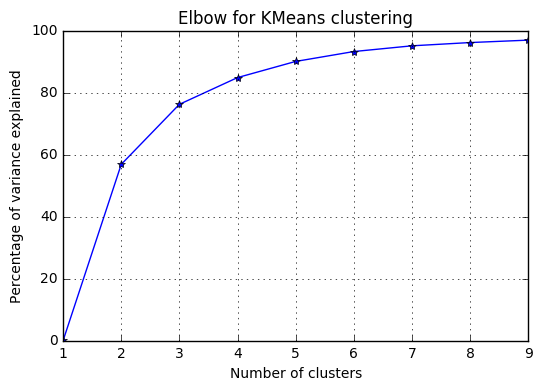

In [39]:
elbow(temp_data2000, range(1, 10))

Figure 4: The figures above are plots used for determning the appropriate number of clusters to use for the K-Means clustering algorithm. 

In [40]:
# KMeans clustering for 2000  
n = 4
km = KMeans(n_clusters = n, random_state = 123)
temp_data2000['cluster'] = km.fit_predict(temp_data2000)

# Appending cluster labels to data2000 demographic dataframe
data2000['cluster2000'] = temp_data2000['cluster']

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [41]:
# KMeans clustering for 2010  
n = 4
km = KMeans(n_clusters = n, random_state = 123)
temp_data2010['cluster'] = km.fit_predict(temp_data2010)

# Appending cluster labels to data2010 demographic dataframe
data2010['cluster2010'] = temp_data2010['cluster']

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### 9) Identify the census tracts that have changed cluster assignment 

In [42]:
# Merging year 2000 and year 2010 dataframes
alldata = gp.GeoDataFrame(pd.concat([data2000, data2010], axis = 1))

In [43]:
# Create boolean to determine which tracts have changed
alldata['changed'] = alldata['cluster2000'] != alldata['cluster2010']
alldata = alldata.loc[:,~alldata.columns.duplicated()]

alldata.head(3)

,geometry,geo_id2,BoroName,geo_display_label,total_population,percent_white,median_age,med_household_inc,cluster2000,cluster2010,changed
0,POLYGON ((-74.07920577013245 40.64343078374566...,36085000900,Staten Island,"Census Tract 9, Richmond County, New York",2109.0,37.8,33.2,35703.0,3,0,True
1,"POLYGON ((-74.05974734759452 40.5938486115672,...",36085007400,Staten Island,"Census Tract 74, Richmond County, New York",3644.0,83.5,35.7,30604.0,3,3,False
2,"POLYGON ((-73.96432543478758 40.7563815309909,...",36061009800,Manhattan,"Census Tract 98, New York County, New York",7066.0,85.2,37.8,67482.0,0,2,True


#### Plotting the data

(-74.299999999999997,
 -73.699999999999989,
 40.400000000000006,
 41.000000000000007)

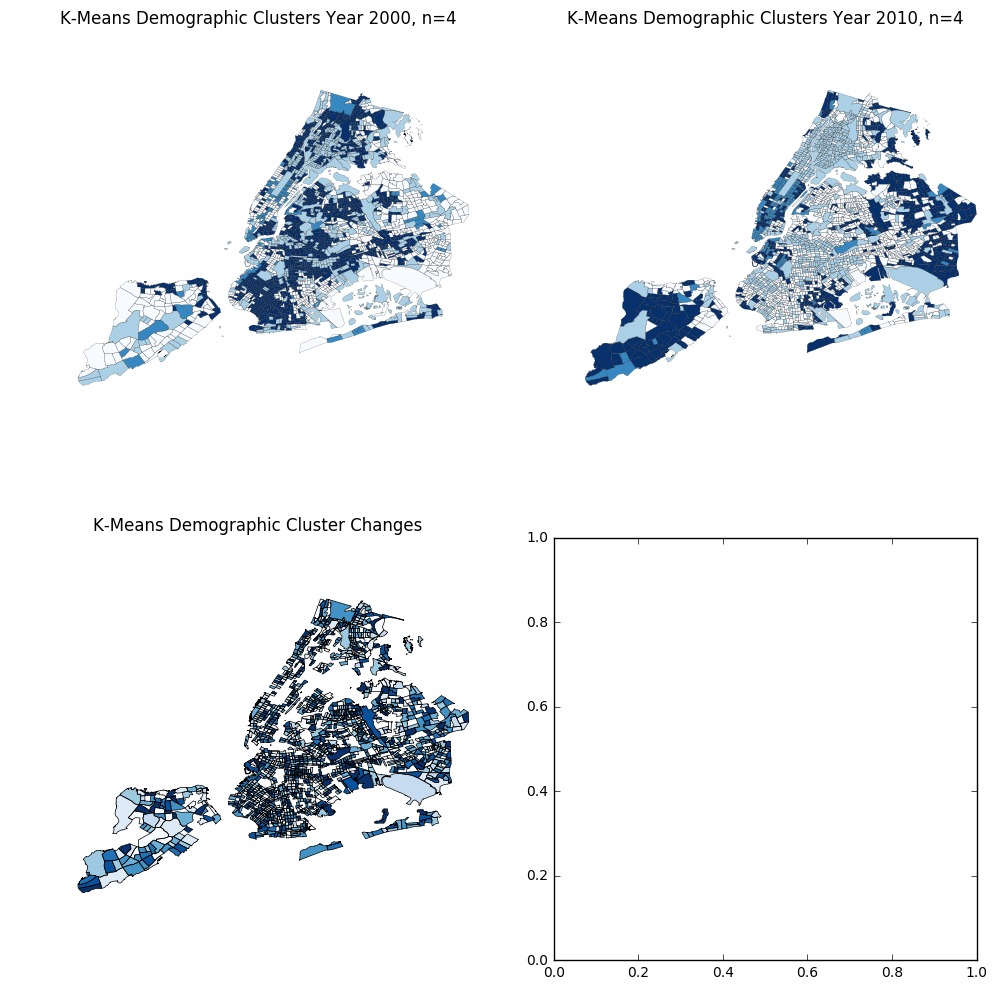

In [44]:
f, ((ax1, ax2), (ax3, ax4)) = pl.subplots(2, 2, figsize=(12,12))

data2000.plot(column='cluster2000',cmap = 'Blues',alpha=1,linewidth=0.1,ax=ax1)
ax1.set_title('K-Means Demographic Clusters Year 2000, n=4')
ax1.axis('off')

data2010.plot(column='cluster2010',cmap = 'Blues',alpha=1,linewidth=0.1,ax=ax2)
ax2.set_title('K-Means Demographic Clusters Year 2010, n=4')
ax2.axis('off')

alldata.query('changed == True').plot(cmap = 'Blues',alpha=1,linewidth=0.5,ax=ax3)
ax3.set_title('K-Means Demographic Cluster Changes')
ax3.axis('off')

ax4.axis('off')

Figure 5: The figures above are the New York City demographic clusters for the years 2000 and 2010 at the census tract level. By 2010 there have been substantial changes to the clustering of the census tracts. The changes of clusters may be an indicator of gentrification or other patterns that have driven a change in census tract demographics. 

The bottom figure shows the specific census tract clusters that changed between years 2000 and 2010. 

### 10) Aggregate the census demographic features at the zipcode level and merge the zipcode dataframe

In [45]:
# Creating points for each census tract
data2000['geometry'] = data2000.geometry.centroid
data2010['geometry'] = data2000.geometry.centroid

In [46]:
# Joining demographic data with zip codes using geopandas spatial join
# Documentation:(http://geopandas.org/mergingdata.html)
zipdata2000 = gp.sjoin(zip_codes,data2000, how = 'left')
zipdata2010 = gp.sjoin(zip_codes,data2010, how = 'left')

In [47]:
zipdata2000.head()

,PO_NAME,borough,geometry,zip,index_right,geo_id2,BoroName,geo_display_label,total_population,percent_white,median_age,med_household_inc,cluster2000
0,Jackson Heights,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372,483.0,3.608103e+10,Queens,"Census Tract 287, Queens County, New York",6545.0,57.9,38.6,37895.0,3.0
0,Jackson Heights,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372,481.0,3.608103e+10,Queens,"Census Tract 283, Queens County, New York",8241.0,52.2,35.5,40025.0,3.0
0,Jackson Heights,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372,484.0,3.608103e+10,Queens,"Census Tract 289, Queens County, New York",5484.0,48.3,37.2,41639.0,3.0
0,Jackson Heights,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372,931.0,3.608103e+10,Queens,"Census Tract 291, Queens County, New York",7120.0,35.9,35.0,36892.0,3.0
0,Jackson Heights,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372,482.0,3.608103e+10,Queens,"Census Tract 285, Queens County, New York",4979.0,65.2,41.3,46276.0,0.0


In [48]:
# Aggregating data at zipcode level
means2000 = zipdata2000.groupby(['zip']).mean()
means2000 = means2000[['total_population','percent_white','median_age','med_household_inc']]
means2000['zip'] = means2000.index


means2010 = zipdata2010.groupby(['zip']).mean()
means2010 = means2010[['total_population','percent_white','median_age','med_household_inc']]
means2010['zip'] = means2010.index

means2000.head()

,total_population,percent_white,median_age,med_household_inc,zip
zip,,,,,
83,18.000000,44.400000,38.500000,18750.000000,83
10001,2149.333333,63.566667,37.000000,53814.666667,10001
10002,6061.142857,35.821429,37.857143,25544.357143,10002
10003,5294.300000,77.980000,33.970000,67424.400000,10003
10004,481.666667,80.100000,31.100000,62235.666667,10004


### 11) Repeat steps 7,8,9 at the zipcode level, include business density

In [49]:
# Merge mean census demographic data with zipcodes
zipdata2000 = pd.merge(zipdata2000, means2000, how = 'left', on = 'zip')
zipdata2010 = pd.merge(zipdata2010, means2010, how = 'left',on = 'zip')
zipdata2000['density'] = biz2000['density']
zipdata2010['density'] = biz2010['density']

zipdata2000 = zipdata2000.drop_duplicates(['zip'], keep = 'first')
zipdata2010 = zipdata2010.drop_duplicates(['zip'], keep = 'first')

zipdata2000 = zipdata2000.fillna(0.0)
zipdata2010 = zipdata2010.fillna(0.0)

zipdata2000.head()

,PO_NAME,borough,geometry,zip,index_right,geo_id2,BoroName,geo_display_label,total_population_x,percent_white_x,median_age_x,med_household_inc_x,cluster2000,total_population_y,percent_white_y,median_age_y,med_household_inc_y,density
0,Jackson Heights,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372,483.0,3.608103e+10,Queens,"Census Tract 287, Queens County, New York",6545.0,57.9,38.6,37895.0,3.0,7118.600000,51.000,35.500000,39694.300000,1946.032637
10,Glen Oaks,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004,628.0,3.608116e+10,Queens,"Census Tract 1579.02, Queens County, New York",3685.0,54.3,41.9,65774.0,0.0,5457.666667,60.800,41.533333,58212.333333,1704.830751
13,New Hyde Park,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040,0.0,0.000000e+00,0,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.000000,0.000000,0.000000
14,Bellerose,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426,1825.0,3.608116e+10,Queens,"Census Tract 1621, Queens County, New York",6181.0,49.9,34.9,53812.0,0.0,4093.200000,57.300,38.700000,50010.600000,949.706684
19,Fresh Meadows,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365,753.0,3.608114e+10,Queens,0,0.0,0.0,0.0,0.0,1.0,3986.000000,37.725,28.650000,40521.125000,0.000000


In [50]:
zipdata2000.rename(columns={'total_population_y': 'zip_pop', 'percent_white_y': 'zip_percent_white', 'median_age_y':'zip_age',
                            'med_household_inc_y':'zip_income'}, inplace=True)
zipdata2010.rename(columns={'total_population_y': 'zip_pop', 'percent_white_y': 'zip_percent_white', 'median_age_y':'zip_age',
                            'med_household_inc_y':'zip_income'}, inplace=True)

#### Plotting the data

(-74.299999999999997,
 -73.599999999999994,
 40.400000000000006,
 41.000000000000007)

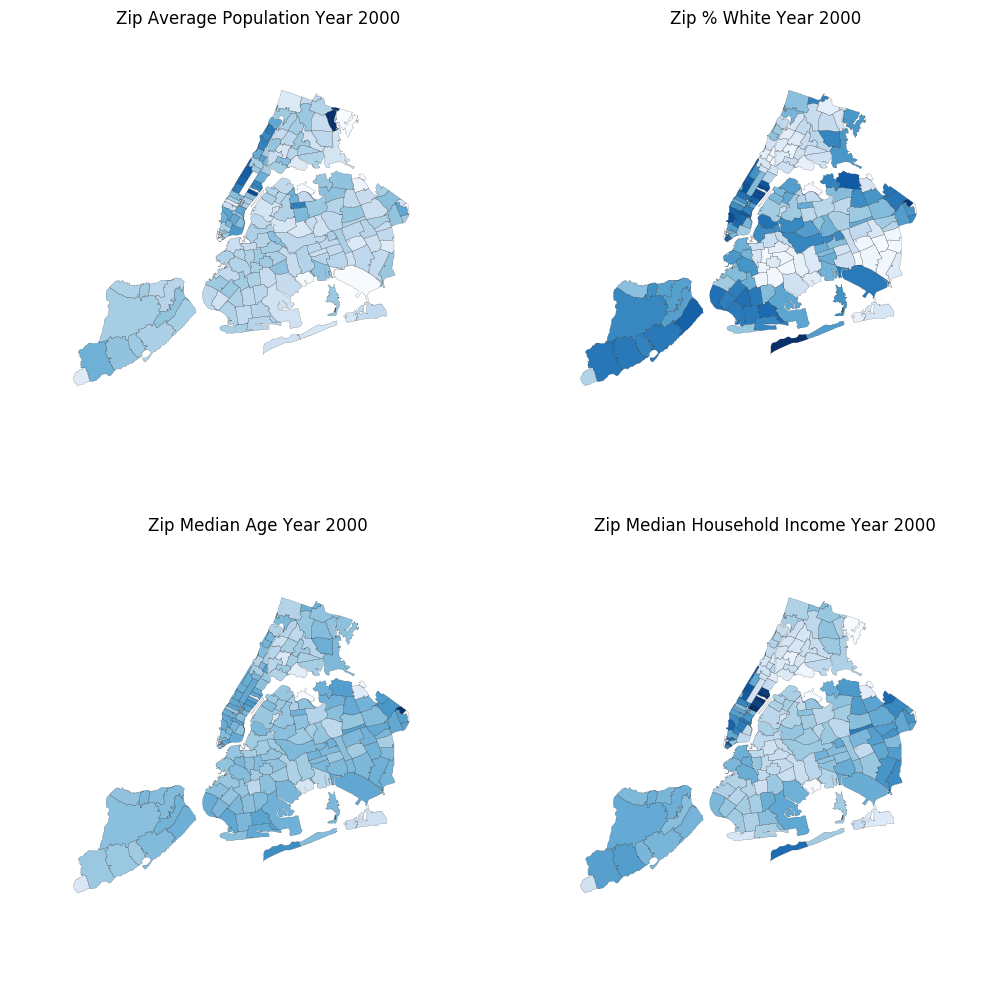

In [51]:
f, ((ax1, ax2), (ax3, ax4)) = pl.subplots(2, 2, figsize=(12,12))
pl.title('Year 2000 Demographic Data')

zipdata2000.plot(column='zip_pop',cmap='Blues',alpha=1,linewidth=0.1,ax=ax1)
ax1.set_title('Zip Average Population Year 2000')
ax1.axis('off')

zipdata2000.plot(column='zip_percent_white',cmap='Blues',alpha=1,linewidth=0.1,ax=ax2)
ax2.set_title('Zip % White Year 2000')
ax2.axis('off')

zipdata2000.plot(column='zip_age',cmap='Blues',alpha=1,linewidth=0.1,ax=ax3)
ax3.set_title('Zip Median Age Year 2000')
ax3.axis('off')

zipdata2000.plot(column='zip_income',cmap='Blues',alpha=1,linewidth=0.1,ax=ax4)
ax4.set_title('Zip Median Household Income Year 2000')
ax4.axis('off')

Figure 6: The figures above represent demographic data for the year 2000 in New York City at the zip code level. a) This figure shows the population of each zip code for NYC. The higher populations apear on the upper west side, Harlem and the Bronx. b) This figure shows the percentage of the white population for each zip code. There are high white populations in mid to lower Manhattan, Staten Island, outskirts of Queens, and southern Brooklyn. c) This figure shows the median age for each zip code. d) This figure shows the median household income for each census tract. The highest median household income appear from mid to lower Manhattan. 

(-74.299999999999997,
 -73.599999999999994,
 40.400000000000006,
 41.000000000000007)

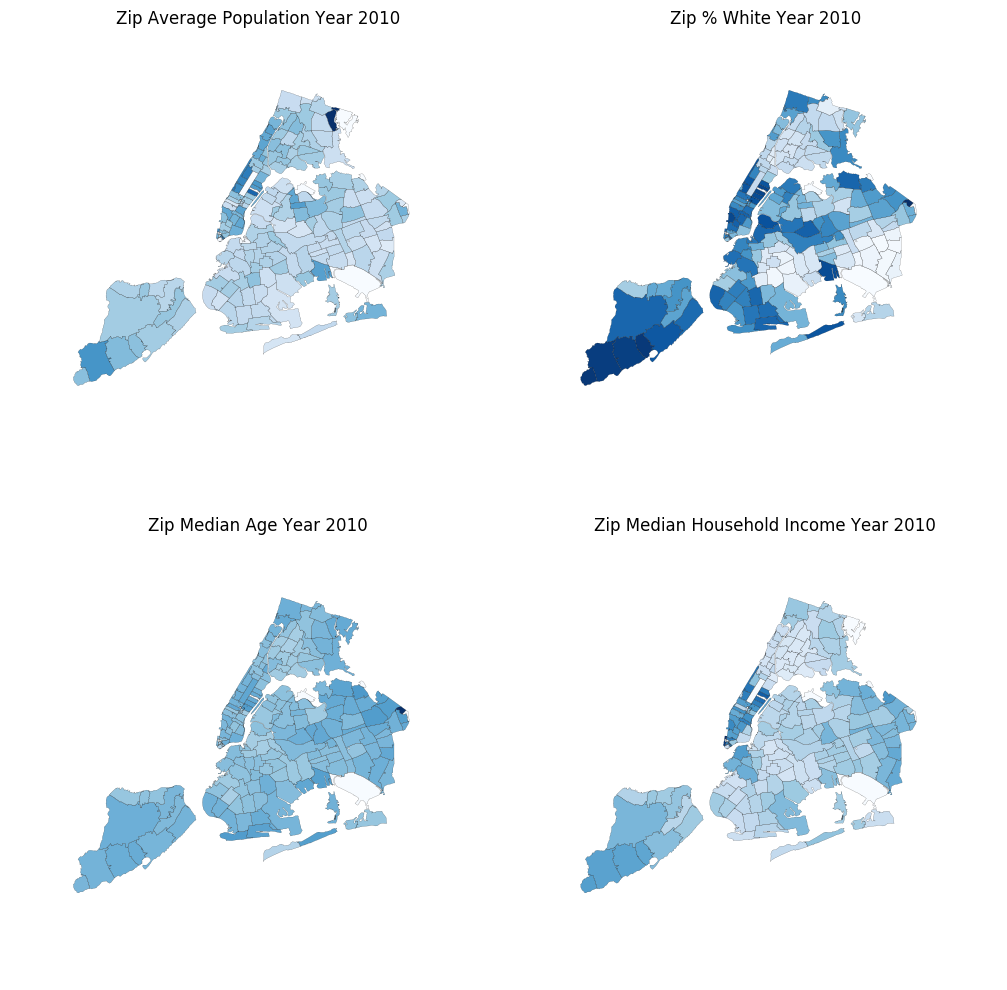

In [52]:
f, ((ax1, ax2), (ax3, ax4)) = pl.subplots(2, 2, figsize=(12,12))
pl.title('Year 2010 Demographic Data')

zipdata2010.plot(column='zip_pop',cmap='Blues',alpha=1,linewidth=0.1,ax=ax1)
ax1.set_title('Zip Average Population Year 2010')
ax1.axis('off')

zipdata2010.plot(column='zip_percent_white',cmap='Blues',alpha=1,linewidth=0.1,ax=ax2)
ax2.set_title('Zip % White Year 2010')
ax2.axis('off')

zipdata2010.plot(column='zip_age',alpha=1,cmap='Blues',linewidth=0.1,ax=ax3)
ax3.set_title('Zip Median Age Year 2010')
ax3.axis('off')

zipdata2010.plot(column='zip_income',cmap='Blues',alpha=1,linewidth=0.1,ax=ax4)
ax4.set_title('Zip Median Household Income Year 2010')
ax4.axis('off')

Figure 7: The figures above represent demographic data for the year 2010 in New York City at the zip code level. a) This figure shows the population of each zip code for NYC. The higher populations apear on the upper west side, Harlem, the Bronx and southernmost tip of Staten Island. b) This figure shows the percentage of the white population for each zip code. There are high white populations in mid to lower Manhattan, Staten Island, outskirts of Queens, and southern Brooklyn. c) This figure shows the median age for each zip code. d) This figure shows the median household income for each census tract. The highest median household income appear from mid to lower Manhattan. 

In [53]:
zipdata2010.shape

(247, 18)

In [54]:
# Need to plot the differences in a 3rd chloropleth map
# zipdiff = pd.DataFrame()
# zipdiff['pop'] = zipdata2000['zip_pop'] / zipdata2010['zip_pop']
# zipdiff['white'] =  zipdata2000['zip_percent_white'] / zipdata2010['zip_percent_white']
# zipdiff['age'] =  zipdata2000['zip_age'] / zipdata2010['zip_age']
# zipdiff['income'] =  zipdata2000['zip_income'] / zipdata2010['zip_income']


# f, ((ax1, ax2), (ax3, ax4)) = pl.subplots(2, 2, figsize=(12,12))
# pl.title('Demographic Changes')

# zipdiff.plot(column='pop',alpha=1,linewidth=0.1,ax=ax1)
# ax1.set_title('Zip Average Population')
# ax1.axis('off')

# zipdiff.plot(column='white',alpha=1,linewidth=0.1,ax=ax2)
# ax2.set_title('Zip % White')
# ax2.axis('off')

# zipdiff.plot(column='age',alpha=1,linewidth=0.1,ax=ax3)
# ax3.set_title('Zip Median Age')
# ax3.axis('off')

# zipdiff.plot(column='income',alpha=1,linewidth=0.1,ax=ax4)
# ax4.set_title('Zip Median Household Income')
# ax4.axis('off')

### Cluster the zipcodes on demographic features

#### Calculating the # of Clusters for K-Means

In [55]:
# Segmenting data for clustering
temp_zipdata2000 = zipdata2000[['zip_pop','zip_percent_white','zip_age','zip_income']]
temp_zipdata2010 = zipdata2010[['zip_pop','zip_percent_white','zip_age','zip_income']]

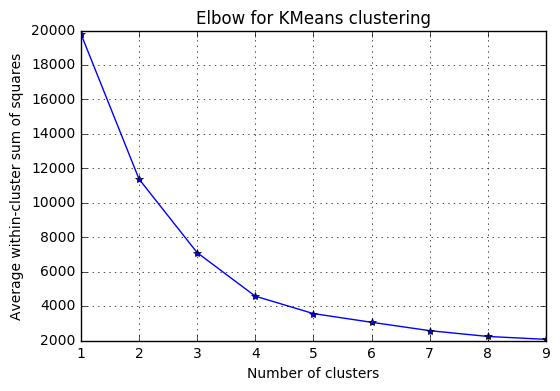

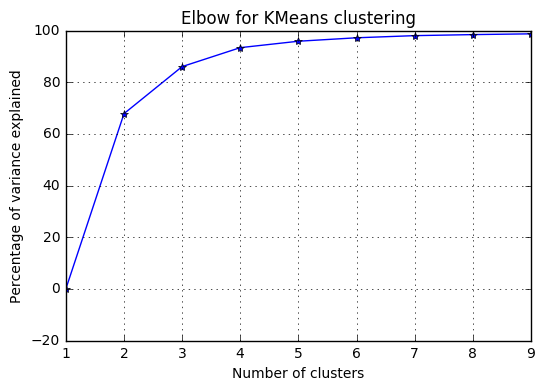

In [56]:
elbow(temp_zipdata2000, range(1, 10))

Figure 8: The figures above are plots used for determning the appropriate number of clusters to use for the K-Means clustering algorithm. 

In [57]:
# KMeans clustering for zipdata2000  
n = 6
km = KMeans(n_clusters = n, random_state = 123)
temp_zipdata2000['cluster'] = km.fit_predict(temp_zipdata2000)

# Appending cluster labels to zipcode demographic dataframe
zipdata2000['cluster2000'] = temp_zipdata2000['cluster']

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [58]:
# KMeans clustering for zipdata2010  
n = 6
km = KMeans(n_clusters = n, random_state = 123)
temp_zipdata2010['cluster'] = km.fit_predict(temp_zipdata2010)

# Appending cluster labels to zipcode demographic dataframe
zipdata2010['cluster2010'] = temp_zipdata2010['cluster']

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Identify the zipcodes that changed cluster assignment

In [59]:
# Merging year 2000 and year 2010 zipcode dataframes
allzipdata = gp.GeoDataFrame(pd.concat([zipdata2000, zipdata2010], axis = 1))

In [60]:
# Create boolean to determine which tracts have changed
allzipdata['changed'] = allzipdata['cluster2000'] != allzipdata['cluster2010']
allzipdata = allzipdata.loc[:,~allzipdata.columns.duplicated()]

allzipdata.head(3)

,PO_NAME,borough,geometry,zip,index_right,geo_id2,BoroName,geo_display_label,total_population_x,percent_white_x,median_age_x,med_household_inc_x,cluster2000,zip_pop,zip_percent_white,zip_age,zip_income,density,cluster2010,changed
0,Jackson Heights,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372,483.0,3.608103e+10,Queens,"Census Tract 287, Queens County, New York",6545.0,57.9,38.6,37895.0,0,7118.600000,51.0,35.500000,39694.300000,1946.032637,3,True
10,Glen Oaks,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004,628.0,3.608116e+10,Queens,"Census Tract 1579.02, Queens County, New York",3685.0,54.3,41.9,65774.0,1,5457.666667,60.8,41.533333,58212.333333,1704.830751,0,True
13,New Hyde Park,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040,0.0,0.000000e+00,0,0,0.0,0.0,0.0,0.0,2,0.000000,0.0,0.000000,0.000000,0.000000,1,True


#### Plotting the data

(0.0, 1.0, 0.0, 1.0)

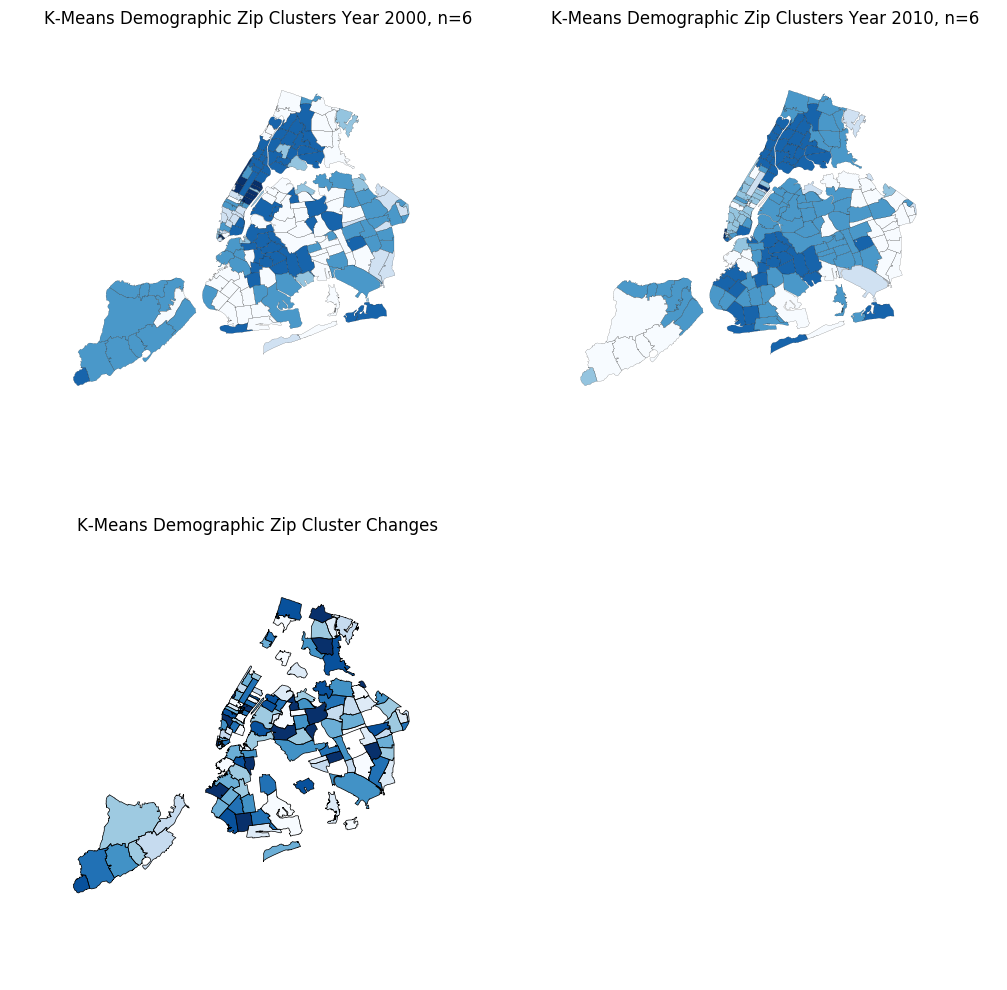

In [61]:
f, ((ax1, ax2), (ax3, ax4)) = pl.subplots(2, 2, figsize=(12,12))

zipdata2000.plot(column='cluster2000',cmap='Blues',alpha=1,linewidth=0.1,ax=ax1)
ax1.set_title('K-Means Demographic Zip Clusters Year 2000, n=6')
ax1.axis('off')

zipdata2010.plot(column='cluster2010',cmap='Blues',alpha=1,linewidth=0.1,ax=ax2)
ax2.set_title('K-Means Demographic Zip Clusters Year 2010, n=6')
ax2.axis('off')

allzipdata.query('changed == True').plot(cmap = 'Blues',alpha=1,linewidth=0.5,ax=ax3)
ax3.set_title('K-Means Demographic Zip Cluster Changes')
ax3.axis('off')

ax4.axis('off')

Figure 9: The figures above are the New York City demographic clusters for the years 2000 and 2010 at the zip code level. By 2010 there have been substantial changes to the clustering of the zip codes. The changes of clusters may be an indicator of gentrification or other patterns that have driven a change in zip code demographics. 
The most noticeable differences are in the centermost part of Staten Island, upper east and upper west side Manhattan, southern Brooklyn and Astoria Queens. 

The bottom figure shows the specific zip code clusters that changed between years 2000 and 2010. 

### 12) Define a function that given a dataframe containing the relevant information and two cluster labels finds if the census tract changed cluster assignments from the first to the second label, and if so finds the individual features that are significantly different as measured by Pearson's correlation, plot those zip codes, and plot a histogram of the features that have significantly changed. Run your function for all label pairs

### 13) Discuss the strengths and weaknesses of this analysis

Strengths: The analysis is helpful becuase it allows you to get a quick overview of neighborhood similarities in New York City. The clustering of multiple demographic data points helped to give a better picture of each neighborhood rather than simply looking at one data point. Aggregating the data at the zip code level was more insightful than the census tract data and put to rest the immediate concern that New York City was changing at a dramatic pace. Though New York City is changing rapidy, the zip code analysis is a little less alarming than the census tract data. I imagine that if I would have calculated the pearson's correlation, I would have more data on which cluster changes were 'more' significant than others. 


Weaknesses: This analysis was helpful in getting a bird's-eye-view of how areas of New York City have changed over the last 10 years but was pretty superficial. In order to be more meaninful, you would need context regarding what is actually causing the neighborhoods to change. One could speculate that gentrification is a large driver for many of the changes observed but I would want to know on a more granular level what is happening in the areas that have changed clusters from the year 2000 to 2010. I'd want more information about how the environment, quality of life, etc in those areas have changed. The census tracts were too small and had much more drastic changes than zip codes that may not accurately reflect meaningful neighborhood changes. 